In [1]:
import os, time, copy, math
from glob import glob
import numpy as np
import pandas as pd
from tqdm import tqdm, trange
from random import seed, shuffle
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from skimage.color import gray2rgb
from utils.myutils import *
from utils.gcnutils import *
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 设置TensorFlow的日志级别为2，只显示error和warining信息

from tensorflow.keras import Model
from tensorflow.keras.models import load_model

In [2]:
data_path = "./data/slices60/"  # 数据路径
model_path = "./model/VGG16/"  # 设置模型保存目录

# 1.读取数据表和数据

In [3]:
# 读入结节信息
dat  = pd.read_csv("/mnt/GCNxin/data/是否微乳头_GNN.csv",encoding = 'utf-8') # 读入GCN初表
dat.sort_values(by=["nID","ID","Z"], ascending=[True, True, True], inplace=True)  # 按结节ID，病人ID，Z轴升序排列
dat

,ID,X,Y,Z,lung,position,Image.type,Pathology,病理分级,Size.cm.,...,脉管瘤栓,淋巴结转移,flag_1,flag_2,flag_3,flag,Zrange,Zmed,slices,nID
0,7,157,222,241,右肺,中叶,纯磨玻璃,MIA,NaN,1.5,...,NaN,NaN,0,0,0,0,"[241, 256]",248,16,0
1,7,157,222,242,右肺,中叶,纯磨玻璃,MIA,NaN,1.5,...,NaN,NaN,0,0,0,0,"[241, 256]",248,16,0
2,7,157,222,243,右肺,中叶,纯磨玻璃,MIA,NaN,1.5,...,NaN,NaN,0,0,0,0,"[241, 256]",248,16,0
3,7,157,222,244,右肺,中叶,纯磨玻璃,MIA,NaN,1.5,...,NaN,NaN,0,0,0,0,"[241, 256]",248,16,0
4,7,157,222,245,右肺,中叶,纯磨玻璃,MIA,NaN,1.5,...,NaN,NaN,0,0,0,0,"[241, 256]",248,16,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10858,635,165,156,183,右肺,中叶,部分实性,腺癌,1.0,1.2,...,无,无,0,0,0,0,"[178, 187]",182,10,482
10859,635,165,156,184,右肺,中叶,部分实性,腺癌,1.0,1.2,...,无,无,0,0,0,0,"[178, 187]",182,10,482
10860,635,165,156,185,右肺,中叶,部分实性,腺癌,1.0,1.2,...,无,无,0,0,0,0,"[178, 187]",182,10,482
10861,635,165,156,186,右肺,中叶,部分实性,腺癌,1.0,1.2,...,无,无,0,0,0,0,"[178, 187]",182,10,482


#### GCN数据初表和npy文件数据列表匹配

In [4]:
# 先将数据表格按结节ID，病人ID，Z轴升序排列，再将获取的数据列表也按相同顺序排列，即可实现一一对应
imagePaths = glob(data_path + "*/*flag_*.npy")  # 所有结节文件
imagePaths.sort(key=lambda x: [int(x.split("nID_")[1].split(",")[0]),
                               int(x.split(" ID_")[1].split(",")[0]),
                               int(x.split("Z_")[1].split("(")[0])], reverse=False)  # 按结节ID，病人ID，切片顺序升序排列文件
print(f"共有{len(imagePaths)}个切片文件")
print(imagePaths[:5])
print(imagePaths[-5:])

共有10863个切片文件
['./data/slices60/neg/nID_0, ID_7, X_157, Y_222, Z_241(241-256), diam_15, flag_0.npy', './data/slices60/neg/nID_0, ID_7, X_157, Y_222, Z_242(241-256), diam_15, flag_0.npy', './data/slices60/neg/nID_0, ID_7, X_157, Y_222, Z_243(241-256), diam_15, flag_0.npy', './data/slices60/neg/nID_0, ID_7, X_157, Y_222, Z_244(241-256), diam_15, flag_0.npy', './data/slices60/neg/nID_0, ID_7, X_157, Y_222, Z_245(241-256), diam_15, flag_0.npy']
['./data/slices60/neg/nID_482, ID_635, X_165, Y_156, Z_183(178-187), diam_12, flag_0.npy', './data/slices60/neg/nID_482, ID_635, X_165, Y_156, Z_184(178-187), diam_12, flag_0.npy', './data/slices60/neg/nID_482, ID_635, X_165, Y_156, Z_185(178-187), diam_12, flag_0.npy', './data/slices60/neg/nID_482, ID_635, X_165, Y_156, Z_186(178-187), diam_12, flag_0.npy', './data/slices60/neg/nID_482, ID_635, X_165, Y_156, Z_187(178-187), diam_12, flag_0.npy']


#### 数据预处理（单通道转RGB三通道）

In [ ]:
# 读取单个npy文件
def get_data_from_file(filePath):
    img_gray = np.load(filePath)  # 读取npy，[60,60]
    img_rgb = gray2rgb(img_gray)  # 第一种办法，灰度图转RGB，[60,60,3]
#     img_rgb = np.repeat(img_gray[..., np.newaxis], 3, -1)  # 第二种办法，单通道复制为3通道，[60,60,3]
    return img_rgb

# 遍历列表，读取多个npy文件，组合成一个batch
def combineBatch(paths):
    batch_data = []
    for path in paths:
        batch_data.append(get_data_from_file(path))
    return np.asarray(batch_data)  # [B,H,W,C]

#### 读取示例

['./data/slices60/pos/nID_12, ID_29, X_404, Y_290, Z_112(109-114), diam_7, flag_1.npy', './data/slices60/pos/nID_12, ID_29, X_404, Y_290, Z_113(109-114), diam_7, flag_1.npy', './data/slices60/pos/nID_12, ID_29, X_404, Y_290, Z_114(109-114), diam_7, flag_1.npy', './data/slices60/neg/nID_13, ID_29, X_188, Y_343, Z_91(91-100), diam_28, flag_0.npy', './data/slices60/neg/nID_13, ID_29, X_188, Y_343, Z_92(91-100), diam_28, flag_0.npy', './data/slices60/neg/nID_13, ID_29, X_188, Y_343, Z_93(91-100), diam_28, flag_0.npy', './data/slices60/neg/nID_13, ID_29, X_188, Y_343, Z_94(91-100), diam_28, flag_0.npy', './data/slices60/neg/nID_13, ID_29, X_188, Y_343, Z_95(91-100), diam_28, flag_0.npy', './data/slices60/neg/nID_13, ID_29, X_188, Y_343, Z_96(91-100), diam_28, flag_0.npy', './data/slices60/neg/nID_13, ID_29, X_188, Y_343, Z_97(91-100), diam_28, flag_0.npy', './data/slices60/neg/nID_13, ID_29, X_188, Y_343, Z_98(91-100), diam_28, flag_0.npy', './data/slices60/neg/nID_13, ID_29, X_188, Y_343, 

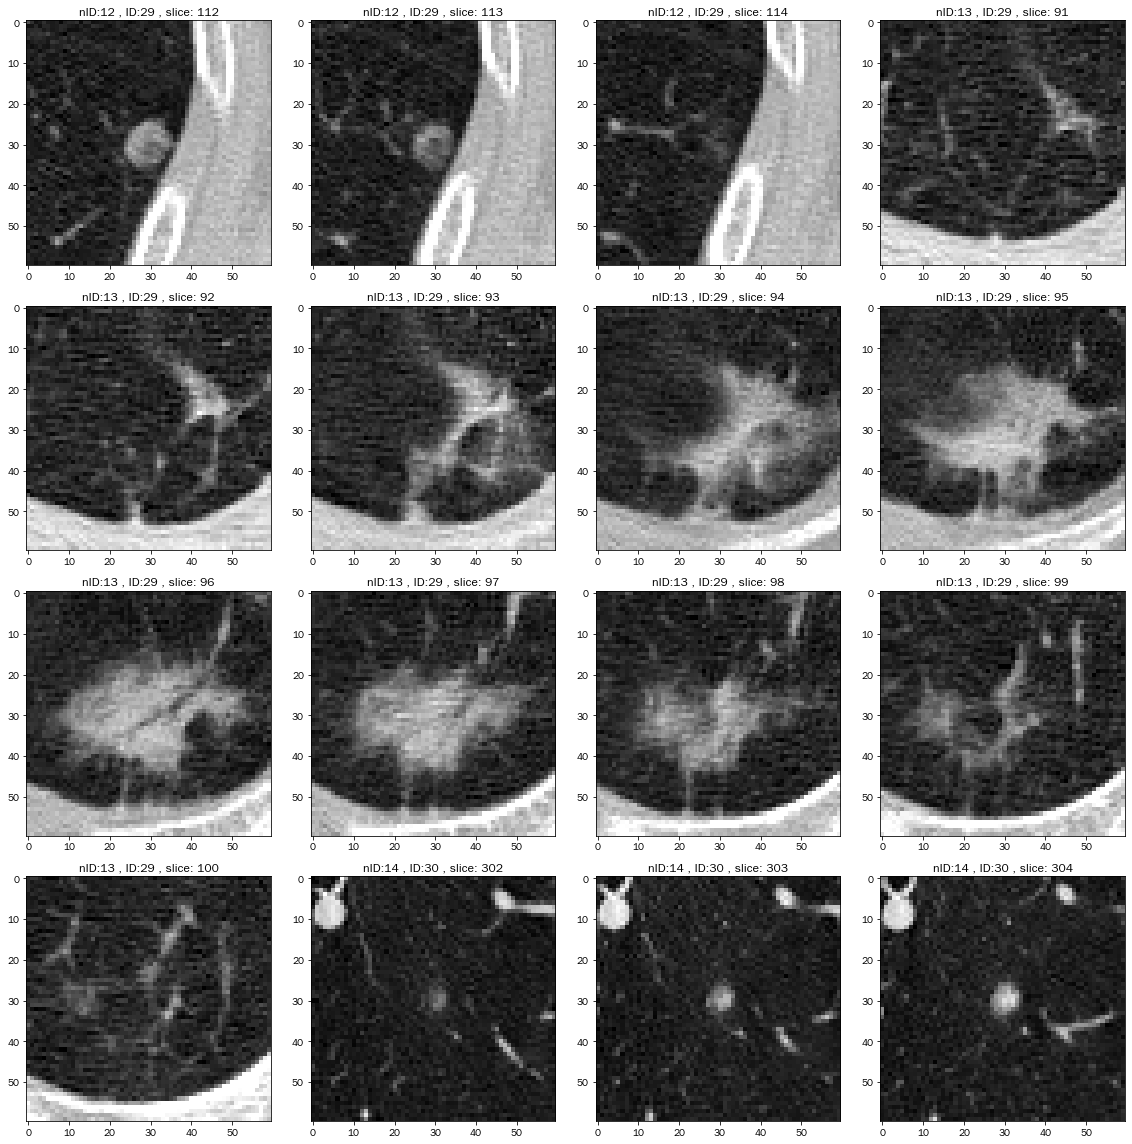

In [6]:
batchPaths = imagePaths[280:296] #读取[280,296]文件路径的切片
print(batchPaths)
batchData = combineBatch(batchPaths)  # batchdata
print(batchData.shape)
rows, cols = math.ceil(len(batchPaths)/4), 4  # 图的行列
print(rows, cols)
fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows), facecolor='white')
axes = axes.flatten()
for i,path in enumerate(batchPaths):
    ax = axes[i]
    ax.imshow(batchData[i,...,2], cmap="gray")  # 展示对应切片的第1通道图像，（图像共有3通道，每个通道的值一样）
    ax.set_title(f"nID:{path.split('nID_')[1].split(',')[0]} , ID:{path.split(' ID_')[1].split(',')[0]} , slice: {path.split('Z_')[1].split('(')[0]}")
plt.tight_layout()
plt.show();

# 2.构建特征提取新模型

In [8]:
# 读取保存的模型
base_model = load_model(model_path + "2023-08-02 04:24:06 VGG16_cbam2fin08_best.h5") #VGG6+CBAM模型
#base_model = load_model(model_path + "2023-08-02 09:54:59 VGG16_08_best.h5") #VGG16模型
#base_model = load_model(model_path + "2023-08-02 11:16:32 VGG16_SA08_best.h5") #VGG16+spatial attention模型
#base_model = load_model(model_path + "2023-08-02 12:26:42 VGG16_CA08_best.h5") #VGG16+channel attention模型

# 查看模型结构
base_model.summary(line_length=120)

Model: "model"
________________________________________________________________________________________________________________________
Layer (type)                                          Output Shape                                    Param #           
input_2 (InputLayer)                                  [(None, 60, 60, 3)]                             0                 
________________________________________________________________________________________________________________________
block1_conv1 (Conv2D)                                 (None, 60, 60, 64)                              1792              
________________________________________________________________________________________________________________________
block1_conv2 (Conv2D)                                 (None, 60, 60, 64)                              36928             
________________________________________________________________________________________________________________________
block1_pool (MaxP

#### 以原模型的输入，倒数第二层（即featuremap层）的输出重新构建新模型

In [9]:
featModel = Model(inputs=base_model.input, outputs=[base_model.layers[-2].output])
for layer in base_model.layers:
    layer.trainable = False  # 设置参数不可训练
featModel.summary(line_length=120)

Model: "model"
________________________________________________________________________________________________________________________
Layer (type)                                          Output Shape                                    Param #           
input_2 (InputLayer)                                  [(None, 60, 60, 3)]                             0                 
________________________________________________________________________________________________________________________
block1_conv1 (Conv2D)                                 (None, 60, 60, 64)                              1792              
________________________________________________________________________________________________________________________
block1_conv2 (Conv2D)                                 (None, 60, 60, 64)                              36928             
________________________________________________________________________________________________________________________
block1_pool (MaxP

# 3.提取特征

#### 将切片数据分batch输入模型，得到各切片的featuremap，最后可以构成特征矩阵

In [10]:
features = []  # 存储每个batch得到的featuremap
batchsize = 50  # 每个batch的数据量
N = len(imagePaths)  # 样本总数
batchs = N // batchsize  # 分多少个batch计算
for ibatch in trange(batchs):  # 遍历每个整数batch
    batchPaths = imagePaths[ibatch * batchsize: (ibatch+1) * batchsize]  # 数据路径切片
    batchData = combineBatch(batchPaths)  # 组合batch数据
    batchfeatures = featModel.predict(batchData)  # 计算featuremap
    features.append(batchfeatures)  # 存储featuremap
# 计算不足整个batch的末尾数据
batchPaths = imagePaths[(ibatch+1) * batchsize: N]  # 数据路径切片
batchData = combineBatch(batchPaths)  # 组合batch数据
batchfeatures = featModel.predict(batchData)  # 计算featuremap
features.append(batchfeatures)  # 存储featuremap
features = np.vstack(features)  # list转array，按第一维度堆叠list中的每个array
featuremap = pd.DataFrame(features)  # array转DataFrame
featuremap.shape

100%|██████████| 217/217 [01:18<00:00,  2.75it/s]


(10863, 512)

In [11]:
batchfeatures.shape

(13, 512)

In [12]:
# 保存featuremap
featuremap.to_csv('/mnt/GCNxin/data/08病人是否微乳头featuremap_vgg_cbam_nonfin622v.csv', index = False, mode="w+") #VGG6+CBAM模型的featuremap
#featuremap.to_csv('/mnt/GCNxin/data/08病人是否微乳头featuremap_vgg_nonfin622v.csv', index = False, mode="w+")  #VGG6模型的featuremap
#featuremap.to_csv('/mnt/GCNxin/data/08病人是否微乳头featuremap_vgg_SA2_nonfin622v.csv', index = False, mode="w+") #VGG16+spatial attention模型
#featuremap.to_csv('/mnt/GCNxin/data/08病人是否微乳头featuremap_vgg_CA2_nonfin622v.csv', index = False, mode="w+") #VGG16+channel attention模型

In [13]:
datGCN = pd.concat([dat, featuremap], axis=1)  # 按行合并原数据表和featuremap
print(datGCN.shape)
# 保存整理好的GCN数据表
datGCN.to_csv('/mnt/GCNxin/data/08病人是否微乳头_VGG16_non_fin622v.csv', index = False, mode="w+") #VGG6+CBAM模型生成的数据表
#datGCN.to_csv('/mnt/GCNxin/data/08病人是否微乳头_VGG16_non_622v.csv', index = False, mode="w+") # VGG6模型生成的数据表
#datGCN.to_csv('/mnt/GCNxin/data/08病人是否微乳头_VGG16_non_SA2_622v.csv', index = False, mode="w+") # VGG16+spatial attention模型生成的数据表
#datGCN.to_csv('/mnt/GCNxin/data/08病人是否微乳头_VGG16_non_CA2_622v.csv', index = False, mode="w+") # VGG16+channel attention模型生成的数据表
datGCN

(10863, 543)


,ID,X,Y,Z,lung,position,Image.type,Pathology,病理分级,Size.cm.,...,502,503,504,505,506,507,508,509,510,511
0,7,157,222,241,右肺,中叶,纯磨玻璃,MIA,NaN,1.5,...,0.880972,0.013824,0.245765,0.000000,0.0,0.163610,0.0,0.000000,0.903040,0.0
1,7,157,222,242,右肺,中叶,纯磨玻璃,MIA,NaN,1.5,...,0.995698,0.025159,0.368413,0.000000,0.0,0.108365,0.0,0.000000,0.912047,0.0
2,7,157,222,243,右肺,中叶,纯磨玻璃,MIA,NaN,1.5,...,1.025030,0.010164,0.330647,0.000955,0.0,0.210163,0.0,0.026221,0.891477,0.0
3,7,157,222,244,右肺,中叶,纯磨玻璃,MIA,NaN,1.5,...,1.215145,0.017059,0.244304,0.007863,0.0,0.620718,0.0,0.000000,0.920998,0.0
4,7,157,222,245,右肺,中叶,纯磨玻璃,MIA,NaN,1.5,...,1.188690,0.042019,0.307710,0.006720,0.0,0.641945,0.0,0.000000,0.909786,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10858,635,165,156,183,右肺,中叶,部分实性,腺癌,1.0,1.2,...,1.321934,0.010252,0.224623,0.021171,0.0,0.601679,0.0,0.000000,0.725457,0.0
10859,635,165,156,184,右肺,中叶,部分实性,腺癌,1.0,1.2,...,1.342240,0.010668,0.138449,0.006280,0.0,0.608893,0.0,0.000000,0.728392,0.0
10860,635,165,156,185,右肺,中叶,部分实性,腺癌,1.0,1.2,...,1.258724,0.011594,0.136840,0.000000,0.0,0.671850,0.0,0.000000,0.726732,0.0
10861,635,165,156,186,右肺,中叶,部分实性,腺癌,1.0,1.2,...,1.299306,0.016477,0.244378,0.000000,0.0,0.774658,0.0,0.000000,0.797309,0.0
